## Final summary

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyspark.sql import SparkSession, functions as F
import lbl2vec
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import numpy as np
import folium
import matplotlib
from pyspark.sql.functions import date_format
from pyspark.sql import SparkSession, functions as F
import seaborn as sns

# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("MAST30034 Project 1 part 1")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZon", "Etc/UTC")
    .config("spark.driver.memory", "4g")
    .config("spark.executor.memory", "8g")
    .getOrCreate()
)

22/10/08 22:13:06 WARN Utils: Your hostname, Aishwaryas-MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 172.16.6.81 instead (on interface en0)
22/10/08 22:13:06 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/10/08 22:13:06 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/10/08 22:13:06 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


### ETL

- The following ETL script downloads the external SA2 datasets and the covid 
data using URLs and then cleans and preprocesses them.
- Next, the script cleans and preprocesses the internal dataset and then merges
it with the external dataset.
- The script prepares a final dataset which is further used throughout the 
analysis to build a ranking model for the merchants.

In [2]:
%run "../scripts/ETL.py" '../scripts/paths.json'

/Users/ahirve/opt/anaconda3/lib/python3.9/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


22/10/08 22:13:07 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


22/10/08 22:14:03 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


### Outlier Analysis

The following dataset is the full internal + external dataset merged together. 

In [3]:
# Show the first five rows of the complete dataset
final_join3.limit(5)

merchant_name,merchant_abn,categories,take_rate,revenue_levels,name,address,state,gender,trans_merchant_abn,dollar_value,order_id,order_datetime,user_id,consumer_id,postcodes,int_sa2,SA2_code,SA2_name,income_2018-2019,total_males,total_females,total_persons,state_code,state_name,population_2020,population_2021,fraud_probability_consumer,fraud_probability_merchant
Egestas Nunc Asso...,11121775571,digital goods: bo...,6.58,a,Christopher Rodri...,30554 Evans Strea...,NSW,Male,11121775571,11.28829564583802,2bd2a61d-72e5-42d...,2021-08-20,3698,1175,2299,111031231,111031231,Shortland - Jesmond,242936885,6412,6179,12593,1,New South Wales,12598,12694,0.01,0.01
Morbi Accumsan In...,19618998054,tent and aWning s...,1.52,c,Christopher Rodri...,30554 Evans Strea...,NSW,Male,19618998054,62.90176609196828,3582b1f8-4577-403...,2021-05-16,3698,1175,2299,111031231,111031231,Shortland - Jesmond,242936885,6412,6179,12593,1,New South Wales,12598,12694,0.01,0.01
Eu Dolor Egestas PC,94472466107,"cable, satellite,...",6.23,a,Christopher Rodri...,30554 Evans Strea...,NSW,Male,94472466107,172.15375126873164,cb05d49f-c2fa-453...,2021-07-22,3698,1175,2299,111031231,111031231,Shortland - Jesmond,242936885,6412,6179,12593,1,New South Wales,12598,12694,0.01,0.01
Urna Justo Indust...,31472801314,music shops - mus...,6.56,a,Christopher Rodri...,30554 Evans Strea...,NSW,Male,31472801314,0.4894787650356477,aeec15c1-67e8-4cb...,2021-05-18,3698,1175,2299,111031231,111031231,Shortland - Jesmond,242936885,6412,6179,12593,1,New South Wales,12598,12694,0.01,0.01
Eu Sem Pellentesq...,35424691626,"computers, comput...",3.9,b,Christopher Rodri...,30554 Evans Strea...,NSW,Male,35424691626,7.360217018778133,9df473ba-102d-461...,2021-07-04,3698,1175,2299,111031231,111031231,Shortland - Jesmond,242936885,6412,6179,12593,1,New South Wales,12598,12694,0.01,0.01


- The outlier script removes the outliers from the above complete dataset in the 
following ways:
    - Removes values with null merchant abn
    - Removes instances with transactions with a dollar value of 0 or less 
    0
    - Removes values with null customer id
    - Remove instances where gender is null

In [4]:

%run "../scripts/outlier.py" '../scripts/paths.json'

22/10/08 22:17:09 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [5]:
df.head()

,Outlier removal,Count after outlier removal
0,Original count,10540321
1,Valid Merchant ABN,10109371
2,Transactions with non $0,10109371
3,Valid customer ID,10109371
4,Non null values for gender,10109371


As seen above, null values were only present in the merchant abn column which
were removed to prepare the final dataset

### Tags to categories


In [6]:
%run "../scripts/NLP.py" '../scripts/paths.json'

22/10/08 22:19:09 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.
THE TOP 15 WORDS FOR TOPIC #FASHION
['new', 'motor', 'stock', 'nursery', 'flowers', 'florists', 'home', 'furnishings', 'appliances', 'manufacturers', 'shoe', 'furniture', 'equipment', 'supplies', 'shops']


THE TOP 15 WORDS FOR TOPIC #FURNITURE
['galleries', 'dealers', 'art', 'telecom', 'service', 'bicycle', 'repair', 'sales', 'artist', 'craft', 'supply', 'watch', 'clock', 'jewelry', 'shops']


THE TOP 15 WORDS FOR TOPIC #ELECTRONICS
['nurseries', 'books', 'periodicals', 'newspapers', 'beauty', 'health', 'spas', 'data', 'design', 'systems', 'processing', 'integrated', 'programming', 'computer', 'services']


THE TOP 15 WORDS FOR TOPIC #BEAUTY, HEALTH, PERSONAL AND HOUSEHOLD
['printing', 'stationery', 'writing', 'instruments', 'pianos', 'musical', 'sheet', 'tent', 'awning', 'digital', 'movies', 'books', 'shops', 'goods', 'music']


THE TOP 15 WORDS FOR TOPIC #TOYS, HOB

In [7]:
merchants_df.head(5)

,name,tags,merchant_abn,cleaned_tags,store_type,category
0,Felis Limited,"((furniture, home furnishings and equipment sh...",10023283211,furniture home furnishings and equipment shops...,0,Furniture
1,Arcu Ac Orci Corporation,"([cable, satellite, and otHer pay television a...",10142254217,cable satellite and other pay television and r...,4,Electronics
2,Nunc Sed Company,"([jewelry, watch, clock, and silverware shops]...",10165489824,jewelry watch clock and silverware shops,1,Toys and DIY
3,Ultricies Dignissim Lacus Foundation,"([wAtch, clock, and jewelry repair shops], [b]...",10187291046,watch clock and jewelry repair shops,1,Toys and DIY
4,Enim Condimentum PC,"([music shops - musical instruments, pianos, a...",10192359162,music shops musical instruments pianos and sh...,3,"Books, Stationary and Music"


### Visualize internal data

22/10/08 22:19:13 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


22/10/08 22:21:33 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


22/10/08 22:23:05 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


AnalysisException: Column 'suburb' does not exist. Did you mean one of the following? [a.name, a.state, a.user_id, a.address, a.gender, a.int_sa2, a.order_id, a.SA2_code, a.SA2_name, a.consumer_id, a.postcodes, a.take_rate, a.categories, a.state_code, a.state_name, a.merchant_abn, a.dollar_value, a.total_males, a.merchant_name, a.total_persons, a.order_datetime, a.revenue_levels, a.total_females, a.population_2020, a.population_2021, a.trans_merchant_abn, a.income_2018-2019, fraud_probability_consumer, fraud_probability_merchant];
'Aggregate [postcodes#1658, 'suburb, 'long, 'lat], [postcodes#1658, 'suburb, 'long, 'lat, count(1) AS count#3822L]
+- Project [merchant_name#1536, merchant_abn#1374L, categories#1513, take_rate#1518, revenue_levels#1524, name#1360, address#1361, state#1362, gender#1364, trans_merchant_abn#1557L, dollar_value#1384, order_id#1385, order_datetime#1386, user_id#1378L, consumer_id#1379L, postcodes#1658, int_sa2#1842, SA2_code#1878L, SA2_name#1879, income_2018-2019#1880L, total_males#1881L, total_females#1882L, total_persons#1883L, state_code#1884L, ... 5 more fields]
   +- Project [merchant_name#1536, merchant_abn#1374L, categories#1513, take_rate#1518, revenue_levels#1524, name#1360, address#1361, state#1362, gender#1364, trans_merchant_abn#1557L, dollar_value#1384, order_id#1385, order_datetime#1386, user_id#1378L, consumer_id#1379L, postcodes#1658, int_sa2#1842, SA2_code#1878L, SA2_name#1879, income_2018-2019#1880L, total_males#1881L, total_females#1882L, total_persons#1883L, state_code#1884L, ... 5 more fields]
      +- Project [merchant_name#1536, merchant_abn#1374L, categories#1513, take_rate#1518, revenue_levels#1524, name#1360, address#1361, state#1362, gender#1364, trans_merchant_abn#1557L, dollar_value#1384, order_id#1385, order_datetime#1386, user_id#1378L, consumer_id#1379L, postcodes#1658, int_sa2#1842, SA2_code#1878L, SA2_name#1879, income_2018-2019#1880L, total_males#1881L, total_females#1882L, total_persons#1883L, state_code#1884L, ... 5 more fields]
         +- Project [merchant_name#1536, merchant_abn#1374L, categories#1513, take_rate#1518, revenue_levels#1524, name#1360, address#1361, state#1362, gender#1364, trans_merchant_abn#1557L, dollar_value#1384, order_id#1385, order_datetime#1386, user_id#1378L, consumer_id#1379L, postcodes#1658, int_sa2#1842, SA2_code#1878L, SA2_name#1879, income_2018-2019#1880L, total_males#1881L, total_females#1882L, total_persons#1883L, state_code#1884L, ... 5 more fields]
            +- Project [merchant_name#1536, merchant_abn#1374L, categories#1513, take_rate#1518, revenue_levels#1524, name#1360, address#1361, state#1362, gender#1364, trans_merchant_abn#1557L, dollar_value#1384, order_id#1385, order_datetime#1386, user_id#1378L, consumer_id#1379L, postcodes#1658, int_sa2#1842, SA2_code#1878L, SA2_name#1879, income_2018-2019#1880L, total_males#1881L, total_females#1882L, total_persons#1883L, state_code#1884L, ... 5 more fields]
               +- Join LeftOuter, ((merchant_abn#1374L = cast(merchant_abn#1462 as bigint)) AND (order_datetime#1386 = cast(order_datetime#1463 as date)))
                  :- SubqueryAlias a
                  :  +- Project [merchant_name#1536, merchant_abn#1374L, categories#1513, take_rate#1518, revenue_levels#1524, name#1360, address#1361, state#1362, gender#1364, trans_merchant_abn#1557L, dollar_value#1384, order_id#1385, order_datetime#1386, user_id#1378L, consumer_id#1379L, postcodes#1658, int_sa2#1842, SA2_code#1878L, SA2_name#1879, income_2018-2019#1880L, total_males#1881L, total_females#1882L, total_persons#1883L, state_code#1884L, ... 4 more fields]
                  :     +- Project [merchant_name#1536, merchant_abn#1374L, categories#1513, take_rate#1518, revenue_levels#1524, name#1360, address#1361, state#1362, gender#1364, trans_merchant_abn#1557L, dollar_value#1384, order_id#1385, order_datetime#1386, user_id#1378L, consumer_id#1379L, postcodes#1658, int_sa2#1842, SA2_code#1878L, SA2_name#1879, income_2018-2019#1880L, total_males#1881L, total_females#1882L, total_persons#1883L, state_code#1884L, ... 4 more fields]
                  :        +- Join LeftOuter, ((user_id#1378L = cast(user_id#1439 as bigint)) AND (order_datetime#1386 = cast(order_datetime#1440 as date)))
                  :           :- SubqueryAlias a
                  :           :  +- Project [merchant_name#1536, merchant_abn#1374L, categories#1513, take_rate#1518, revenue_levels#1524, name#1360, address#1361, state#1362, gender#1364, trans_merchant_abn#1557L, dollar_value#1384, order_id#1385, order_datetime#1386, user_id#1378L, consumer_id#1379L, postcodes#1658, int_sa2#1842, SA2_code#1878L, SA2_name#1879, income_2018-2019#1880L, total_males#1881L, total_females#1882L, total_persons#1883L, state_code#1884L, ... 3 more fields]
                  :           :     +- Join Inner, (cast(int_sa2#1842 as bigint) = SA2_code#1878L)
                  :           :        :- Project [merchant_name#1536, merchant_abn#1374L, categories#1513, take_rate#1518, revenue_levels#1524, name#1360, address#1361, state#1362, gender#1364, trans_merchant_abn#1557L, dollar_value#1384, order_id#1385, order_datetime#1386, user_id#1378L, consumer_id#1379L, postcodes#1658, int_sa2#1842]
                  :           :        :  +- Project [merchant_name#1536, merchant_abn#1374L, categories#1513, take_rate#1518, revenue_levels#1524, name#1360, address#1361, state#1362, gender#1364, trans_merchant_abn#1557L, dollar_value#1384, order_id#1385, order_datetime#1386, user_id#1378L, consumer_id#1379L, postcodes#1658, sa2#1659, cast(sa2#1659 as int) AS int_sa2#1842]
                  :           :        :     +- Project [merchant_name#1536, merchant_abn#1374L, categories#1513, take_rate#1518, revenue_levels#1524, name#1360, address#1361, state#1362, gender#1364, trans_merchant_abn#1557L, dollar_value#1384, order_id#1385, order_datetime#1386, user_id#1378L, consumer_id#1379L, postcodes#1658, sa2#1659]
                  :           :        :        +- Join Inner, (postcode#1363 = postcodes#1658)
                  :           :        :           :- Project [merchant_name#1536, merchant_abn#1374L, categories#1513, take_rate#1518, revenue_levels#1524, name#1360, address#1361, state#1362, postcode#1363, gender#1364, trans_merchant_abn#1557L, dollar_value#1384, order_id#1385, order_datetime#1386, user_id#1378L, consumer_id#1379L]
                  :           :        :           :  +- Project [merchant_name#1536, merchant_abn#1374L, categories#1513, take_rate#1518, revenue_levels#1524, name#1360, address#1361, state#1362, postcode#1363, gender#1364, trans_user_id#1563L, trans_merchant_abn#1557L, dollar_value#1384, order_id#1385, order_datetime#1386, user_id#1378L, consumer_id#1379L]
                  :           :        :           :     +- Join FullOuter, (merchant_abn#1374L = trans_merchant_abn#1557L)
                  :           :        :           :        :- Project [name#1372 AS merchant_name#1536, merchant_abn#1374L, categories#1513, take_rate#1518, revenue_levels#1524]
                  :           :        :           :        :  +- Project [name#1372, merchant_abn#1374L, categories#1513, take_rate#1518, revenue_levels#1524]
                  :           :        :           :        :     +- Project [name#1372, tags#1509, merchant_abn#1374L, categories#1513, take_rate#1518, split(tags#1509, [)\]], [\[(], -1)[1] AS revenue_levels#1524]
                  :           :        :           :        :        +- Project [name#1372, tags#1509, merchant_abn#1374L, categories#1513, cast(split(tags#1509, [)\]], [\[(]take rate: , -1)[1] as double) AS take_rate#1518]
                  :           :        :           :        :           +- Project [name#1372, tags#1509, merchant_abn#1374L, split(tags#1509, [)\]], [\[(], -1)[0] AS categories#1513]
                  :           :        :           :        :              +- Project [name#1372, regexp_replace(tags#1504, [\[(][\[(], , 1) AS tags#1509, merchant_abn#1374L]
                  :           :        :           :        :                 +- Project [name#1372, regexp_replace(tags#1373, [\])][\])], , 1) AS tags#1504, merchant_abn#1374L]
                  :           :        :           :        :                    +- Relation [name#1372,tags#1373,merchant_abn#1374L] parquet
                  :           :        :           :        +- Join Inner, (int_consumer_id#1542L = consumer_id#1379L)
                  :           :        :           :           :- Project [name#1360, address#1361, state#1362, postcode#1363, gender#1364, int_consumer_id#1542L]
                  :           :        :           :           :  +- Project [name#1360, address#1361, state#1362, postcode#1363, gender#1364, consumer_id#1365, cast(consumer_id#1365 as bigint) AS int_consumer_id#1542L]
                  :           :        :           :           :     +- Relation [name#1360,address#1361,state#1362,postcode#1363,gender#1364,consumer_id#1365] csv
                  :           :        :           :           +- Join Inner, (trans_user_id#1563L = user_id#1378L)
                  :           :        :           :              :- Project [user_id#1382L AS trans_user_id#1563L, trans_merchant_abn#1557L, dollar_value#1384, order_id#1385, order_datetime#1386]
                  :           :        :           :              :  +- Project [user_id#1382L, merchant_abn#1383L AS trans_merchant_abn#1557L, dollar_value#1384, order_id#1385, order_datetime#1386]
                  :           :        :           :              :     +- Sort [order_datetime#1386 ASC NULLS FIRST], true
                  :           :        :           :              :        +- Deduplicate [order_id#1385, order_datetime#1386, user_id#1382L, dollar_value#1384, merchant_abn#1383L]
                  :           :        :           :              :           +- Union false, false
                  :           :        :           :              :              :- Deduplicate [order_id#1385, order_datetime#1386, user_id#1382L, dollar_value#1384, merchant_abn#1383L]
                  :           :        :           :              :              :  +- Union false, false
                  :           :        :           :              :              :     :- Relation [user_id#1382L,merchant_abn#1383L,dollar_value#1384,order_id#1385,order_datetime#1386] parquet
                  :           :        :           :              :              :     +- Relation [user_id#1392L,merchant_abn#1393L,dollar_value#1394,order_id#1395,order_datetime#1396] parquet
                  :           :        :           :              :              +- Relation [user_id#1402L,merchant_abn#1403L,dollar_value#1404,order_id#1405,order_datetime#1406] parquet
                  :           :        :           :              +- Relation [user_id#1378L,consumer_id#1379L] parquet
                  :           :        :           +- Deduplicate [postcodes#1658]
                  :           :        :              +- Filter atleastnnonnulls(2, postcodes#1658, sa2#1659)
                  :           :        :                 +- Project [postcode#1587 AS postcodes#1658, SA2_MAINCODE_2016#1604 AS sa2#1659]
                  :           :        :                    +- Relation [id#1586,postcode#1587,locality#1588,state#1589,long#1590,lat#1591,dc#1592,type#1593,status#1594,sa3#1595,sa3name#1596,sa4#1597,sa4name#1598,region#1599,Lat_precise#1600,Long_precise#1601,SA1_MAINCODE_2011#1602,SA1_MAINCODE_2016#1603,SA2_MAINCODE_2016#1604,SA2_NAME_2016#1605,SA3_CODE_2016#1606,SA3_NAME_2016#1607,SA4_CODE_2016#1608,SA4_NAME_2016#1609,... 12 more fields] csv
                  :           :        +- LogicalRDD [SA2_code#1878L, SA2_name#1879, income_2018-2019#1880L, total_males#1881L, total_females#1882L, total_persons#1883L, state_code#1884L, state_name#1885, population_2020#1886L, population_2021#1887L], false
                  :           +- SubqueryAlias b
                  :              +- Relation [user_id#1439,order_datetime#1440,fraud_probability#1441] csv
                  +- SubqueryAlias b
                     +- Relation [merchant_abn#1462,order_datetime#1463,fraud_probability#1464] csv


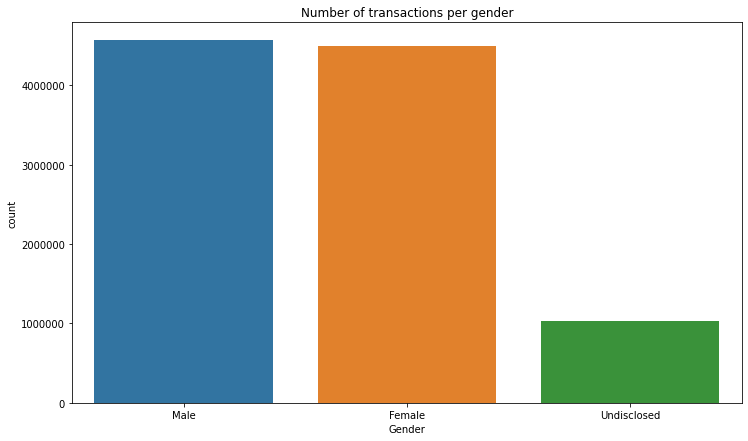

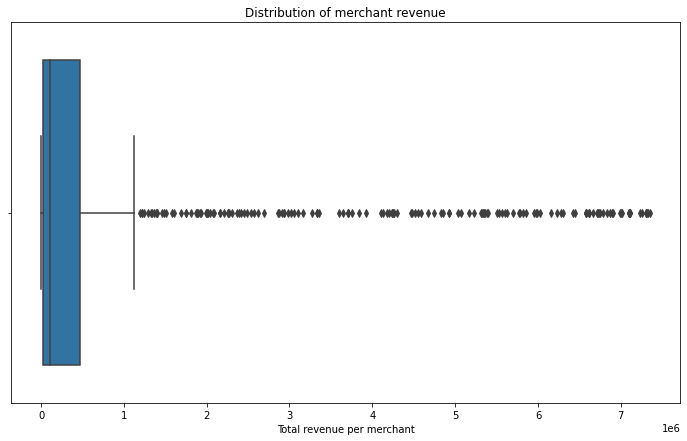

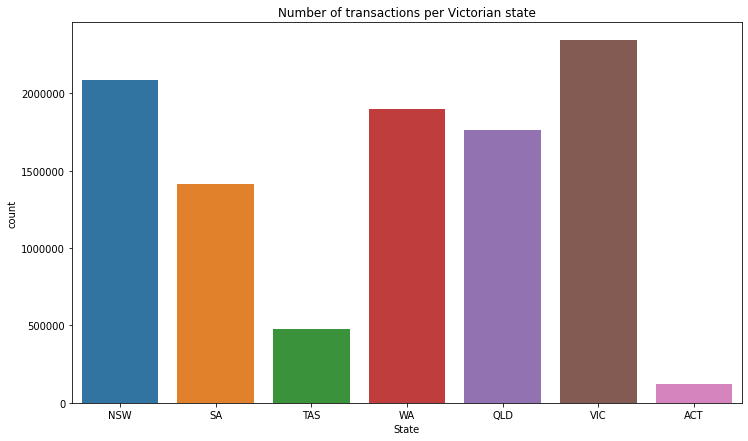

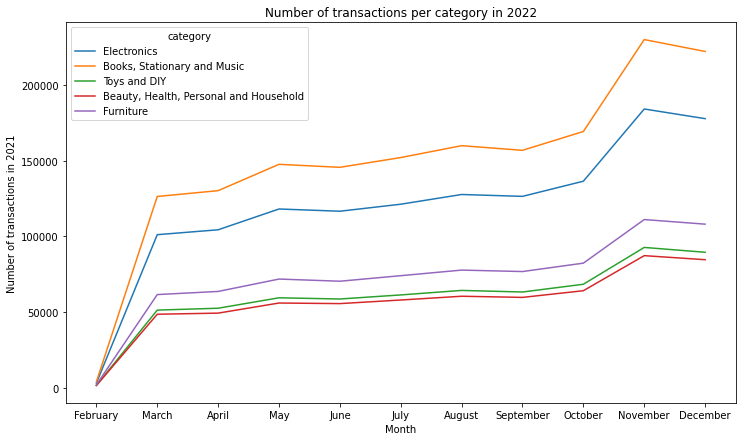

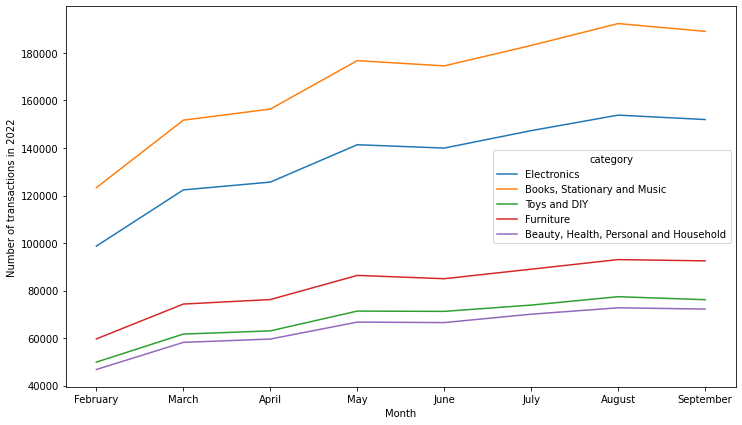

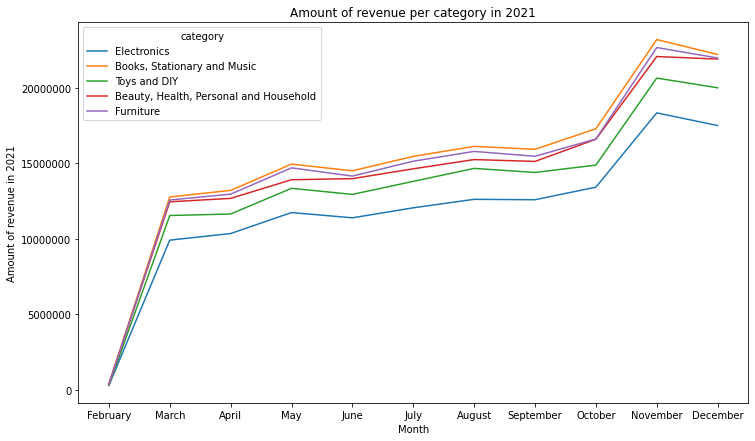

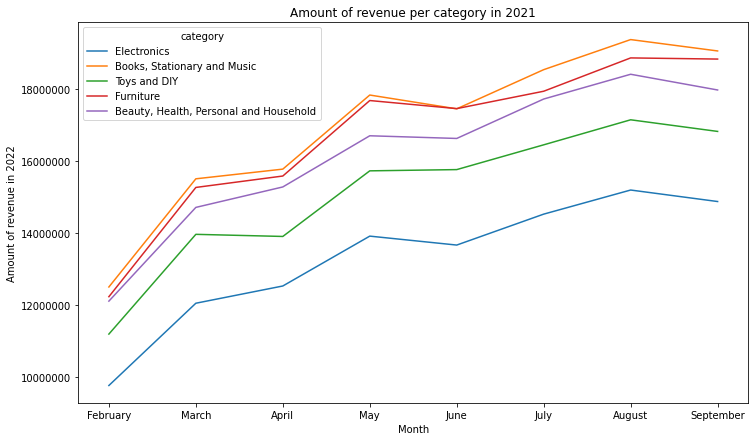

In [8]:
%run "../scripts/visualizations-1.py" '../scripts/paths.json'

### External datasets - Outliers

Summary statistics for the Census data - 


22/10/08 22:31:16 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.
           SA2_code   total_males  total_females  total_persons
count  2.472000e+03   2472.000000    2472.000000    2472.000000
mean   3.177555e+08   5074.887136    5209.415049   10284.254450
std    1.977886e+08   3019.275754    3161.883118    6171.395057
min    1.010210e+08      0.000000       0.000000       0.000000
25%    1.270315e+08   2669.750000    2678.000000    5384.750000
50%    3.030411e+08   4774.000000    4875.000000    9656.000000
75%    4.060111e+08   7169.000000    7511.500000   14675.000000
max    9.999995e+08  14327.000000   13783.000000   28116.000000


Summary statistics for the Income data - 


    SA2_code           SA2_name  income_2018-2019
0  101021007          Braidwood         120763285
1  101021008            Karabar         338308979
2  101021009         Queanbeyan         441160946
3  101021010  

[]


Summary statistics for the Population data - 


    SA2_code                         SA2_name  state_code       state_name  \
0  101021007                        Braidwood           1  New South Wales   
1  101021008                          Karabar           1  New South Wales   
2  101021009                       Queanbeyan           1  New South Wales   
3  101021010                Queanbeyan - East           1  New South Wales   
4  101021012  Queanbeyan West - Jerrabomberra           1  New South Wales   

   population_2020  population_2021  
0             4273             4330  
1             8519             8546  
2            11437            11370  
3             5077             5093  
4            12796            12743  


Summary statistics for the population in 2020 per SA2 code data - 


count     2454.000000
mean     10454.477995
std       6229.349880
min          0.000000
25%       5449.500000
50%       9778.000000
75%      14832.750000
max      28250.000000
Nam

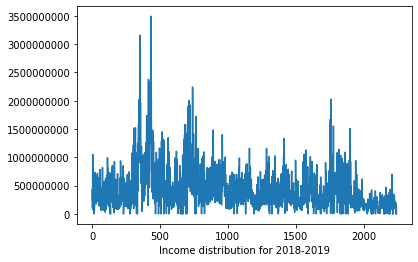

In [9]:
%run "../scripts/outlier_external.py" '../scripts/paths.json'

### Ranking models 

In [10]:
%run "../scripts/BNPL_earning_model.py" '../scripts/paths.json'

Exception: File `'../scripts/BNPL_earning_model.py'` not found.

In [ ]:
# Run all the models to get the features for the ranking model
%run "../scripts/Revenue_model.py" '../scripts/paths.json'

In [ ]:
%run "../scripts/Customers_model.py" '../scripts/paths.json'

In [ ]:
%run "../scripts/Transactions_model.py" 

In [ ]:
%run "../scripts/fraud_feature.py" '../scripts/paths.json'

In [ ]:
# take list of values as weights for fraud, transactions, revenue, customer, take rate
%run '../scripts/ranking_model.py' 4,2,1,3,5

In [ ]:
%run "../scripts/rank_visualisation.py" 

In [ ]:
final_rank.head()